In [1]:
import tensorflow as tf
import imageio
from matplotlib.pyplot import imshow
import numpy as np
import scipy.misc
from config import *
from vgg_util import *
%matplotlib inline

# Neural Style Transfer

### 1. What is neural style transfer?

Gatys et al. showed an interesting approach using convolutional networks to transfer styles of images. Using convolutional layers we can generate a new image with the content of one and the style of another one.

| Content Image ( The Reformed Great Church - Debrecen, Hungary ) | Style Image ( The Starry Night - Vincent van Gogh ) |
| ---------------------------------| ---------------------------------|
| ![](images/debrecen.jpg?raw=true) | ![](images/vincent.jpg?raw=true)

| Generated image |
| --- |
| <img src="images/debrecen-vincent.png" width="400" height="400" /> |

| Content Image ( London ) | Style Image ( Pablo Picasso, Houses on the hill ) |
| ---------------------------------| ---------------------------------|
| <img src="images/london.jpg" width="400" height="400" />  | ![](images/picasso.jpg?raw=true)

| Generated image |
| --- |
| <img src="images/london-picasso.png" width="400" height="400" /> |

[](images/debrecen.jpg?raw=true)

Convolutional neural networks have shown remarkable results in the field of image classification, object detection and face recogniton problems.
Convolutional layers have the following characteristics that makes them more efficient then fully connected layers in the field of image processing

* **Parameter Sharing**
    same filter/ feature detection is applied to different parts of the source input/image
* **Sparsity of connections**
    each output value depends on a subset of the input values, in case of fully connected layers every output value depends on every input value

### 2. What is convolutional network?

##### VGG-19 Very Deep Convolutional Networks for Large-Scale Image Recognition

<img src="resources/vgg-19.png" width="850" height="220" /> 
Source: https://www.slideshare.net/ckmarkohchang/applied-deep-learning-1103-convolutional-neural-networks

In a convolutional architecture every unit in layer l depends on a subset of input values from layer l-1

<img src="resources/LeNet_5_LeCunn.png" width="850" height="220" /> 
Architecture of CNN by LeCun et al. (LeNet-5).

##### Convolution operation

<table>
  <tr>
    <td><img width="150px" src="resources/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="resources/full_padding_no_strides.gif"></td>
    <td><img width="150px" src="resources/no_padding_strides.gif"></td>
    <td><img width="150px" src="resources/padding_strides.gif"></td>
  </tr>
  <tr>
    <td><big>No padding, no strides</big></td>
    <td><big>Full padding, no strides</big></td>
    <td><big>No padding, strides</big></td>
    <td><big>Padding, strides</big></td>
  </tr>
</table>
Image source: Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning https://github.com/vdumoulin/conv_arithmetic

A convolution neural network architecture usually contains series of convolutional operations followed by a max pooling layer, ended by a number of fully connected layers.
VGG-19 is a 19 layer convolutional neural network trained on millions of Imagenet Images and able to classify images of 1000 images

### 3. Neural style transfer algorithm

Input(Content image - C, Style image - S)
1. Initiate a random image G
2. Define a cost function that calculates:
    * content cost - difference in content between generated image G and content image C
    * style cost - difference in style between generated image G and style image S
    Total cost = α * content_cost + β * style cost
    where α and β are hyperparameters defining the weight on content and cost
3. Using gradient descent minimize cost function by updating G

##### Configuration

In [2]:
config = Config()

##### Load content and style image

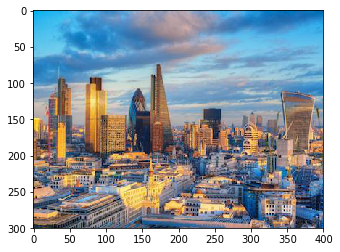

In [3]:
content_image = imageio.imread("images/london.jpg")
imshow(content_image)

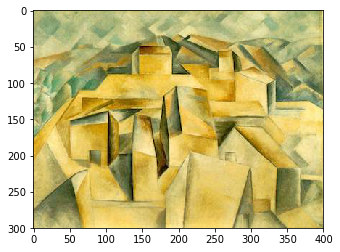

In [4]:
style_image = imageio.imread("images/picasso.jpg")
imshow(style_image)

##### Reshape and normalize input images

In [5]:
def normalize(image):
    """
    Normalize the input image (content or style)
    """
    #reshape to have a 4th dimension
    image = np.reshape(image, ((1,) + image.shape))
    # apply vgg19 normalization 
    image = image - config.means
    
    return image
content_image = normalize(content_image)
style_image = normalize(style_image)

##### Initiate random image

In [6]:
def generate_random_image(content_image, noise_ratio):
    #draw samples from an even distribution with the given shape 
    uniform_dist_rand_values = np.random.uniform(-20, 20, (1, config.height, config.width, config.channels)).astype('float32')
    
    #set the generated image to be weighted image from the random values and the content image
    generated_image = uniform_dist_rand_values * noise_ratio + content_image * ( 1 - noise_ratio)
    
    return generated_image

In [7]:
generated_image = generate_random_image(content_image, config.noise_ratio)

##### Define content cost function

How do you define a content of an image? What is the content?

In order to generate an image that has the same objects and shapes that the content image has, we have to copy the higher level more complex shapes and forms and also the fine details from lower levels. If you choose a layer that is to shallow the generated image may miss out complex shapes and forms, if you choose a layer that is too deep the generated image may miss out on fine level details of the content.

We can define the cost function as the squared difference of the content and generated image
$$content\_cost(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [8]:
def calc_content_cost(content, generated):
    """
    Returns the content cost
    """
    
    n, height, width, channels = generated.get_shape().as_list()
    
    #Convert images to a 1 dimensional array, to make the calculation of cost easier
    content_array = tf.reshape(content,[-1])
    generated_array = tf.reshape(generated, [-1])
    
    content_cost = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(content_array,generated_array)),axis = 0),1/(4 * height*width*channels))
    
    return content_cost

##### Define style cost function

How do you define the style of an image?

<figure><img src="resources/conv_layers.png" width="400" height="400"/></figure>
Source: Zeiler, Matthew D., and Rob Fergus. "Visualizing and understanding convolutional networks." European conference on computer vision. Springer, Cham, 2014.

How do you define the style of an image? 

The style of an image can be defined as the correlation across channels.
Let's say in layer l we applied n filter/kernel on our input resulting in an x * y * n output where n will be the number of channels( See Figure 3. Each kernel recognises different characteristics of the input. 

$$style\_cost^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2 $$

In [9]:
def calc_style_cost(style, generated):
    """
    Return the style cost
    """
    n, height, width, channels = generated.get_shape().as_list()
    
    # Reshape input to have shape (number_of_channels, width * height)
    # Each channels corresponds to a 1 dimensional array, this maker the calculation easier
    style = tf.reshape(tf.transpose(style),[channels, height * width])
    generated = tf.reshape(tf.transpose(generated),[channels, height * width])
    
    
    # Gram matrix will reflect the correlation between channels
    # higher values will mean, the input values on those locations are higher
    style_gram = tf.matmul(style,tf.transpose(style))
    generated_gram = tf.matmul(generated,tf.transpose(generated))
    
    # Squared difference of the gram matrices will give use the style cost
    style_cost = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(style_gram,generated_gram))),1/(4*channels*channels*(height*width)**2))
    
    return style_cost

To achieve even better results and learn more style of the input image  we will use the average style cost of different layers in the network.

In [10]:
STYLES_FROM_LAYERS = ['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1']

The overall style cost can be summarized as:

$$overall\_style\_cost(S,G) = \frac{\sum_{l} \ style\_cost^{[l]}(S,G)}{l}   $$

##### Define the total cost

The total cost is the sum of the content and style cost, multiplied by a weight that we can parametirize and tune as hyperparameters. They define the weighting between the content cost and style cost.

$$total\_cost(C,S,G) = \alpha * content\_cost(C,G) + \beta * overall\_style\_cost(S,G)$$

In [11]:
def calc_total_cost(content_cost, style_cost, alpha, beta):
    return alpha * content_cost + beta * style_cost

Now we have all the functions needed to learn the style and the content of our input images, lets plug them together

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

##### Load VGG-19 model

In [13]:
model = get_vgg_graph()

##### Compute content cost 

Load content image to the input tensor, and get output values from 'relu4_2'

In [14]:
sess.run(model['input'].assign(content_image))

output_tensor = model['relu4_2']

#get the output values from the layer by running the session and evaluating the layer
output_values = sess.run(output_tensor)

#NOTE output_tensor is not yet evaluated, and is going to be evaluated later, it represent the tensor only at the moment
content_cost = calc_content_cost(output_values,output_tensor)

Similarly as above load the sytle image to the input tensor, and get output values, but now from all the style_layers defined before and get average

In [15]:
sess.run(model['input'].assign(style_image))

total_style_cost = 0

for layer_name in STYLES_FROM_LAYERS:
    #get the output tensor of the given layer_name from the graph
    layer_tensor = model[layer_name]
        
    #get the output values from the layer_tensor
    layer_style_output = sess.run(layer_tensor)
        
    #NOTE layer_tensor is not yet evaluated, and is going to be evaluated later, it represent the tensor only at the moment   
    layer_style_cost = calc_style_cost(layer_style_output, layer_tensor)
        
    total_style_cost += layer_style_cost
    
total_style_cost = total_style_cost / len(STYLES_FROM_LAYERS)

Compute total cost

In [16]:
total_cost = calc_total_cost(content_cost, total_style_cost, 10, 40)

##### Set up Adam Optimizer

In [17]:
optimizer = tf.train.AdamOptimizer(1.5)

step = optimizer.minimize(total_cost)

In [ ]:
def run_model(sess, input_image, num_iterations = 300):
    
    #Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    #Run the the generated random image through the graph
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        
        sess.run(step)
        #The output values will give the generated image
        generated_image_value = sess.run(model['input'])
        
        
        #print results
        total_cost_value, content_cost_value, style_cost_value = sess.run([total_cost, content_cost, total_style_cost])
        
        print("Iteration ", str(i), " :", "total cost = ", str(total_cost_value), "content cost = ", str(content_cost_value), "style cost = ", str(style_cost_value))
        #Save denormalised image on disk
        
        if(i == num_iterations-1):
            generated_image_value = generated_image_value + config.means
            scipy.misc.imsave("output/" + str(i) + ".png", np.clip(generated_image_value[0], 0, 255).astype('uint8'))


In [ ]:
run_model(sess, generated_image)

Iteration  0  : total cost =  1.60637e+11 content cost =  59332.3 style cost =  4.01591e+09
Iteration  1  : total cost =  1.36073e+11 content cost =  55399.4 style cost =  3.40181e+09
Iteration  2  : total cost =  1.16786e+11 content cost =  55055.7 style cost =  2.91965e+09
Iteration  3  : total cost =  1.01823e+11 content cost =  56439.3 style cost =  2.54556e+09
Iteration  4  : total cost =  9.01369e+10 content cost =  58730.4 style cost =  2.25341e+09
Iteration  5  : total cost =  8.08006e+10 content cost =  61506.0 style cost =  2.02e+09
Iteration  6  : total cost =  7.30299e+10 content cost =  64550.9 style cost =  1.82573e+09
Iteration  7  : total cost =  6.6402e+10 content cost =  67708.3 style cost =  1.66003e+09
Iteration  8  : total cost =  6.07065e+10 content cost =  70853.0 style cost =  1.51764e+09
Iteration  9  : total cost =  5.57313e+10 content cost =  73886.9 style cost =  1.39326e+09
Iteration  10  : total cost =  5.13674e+10 content cost =  76725.8 style cost =  1.2

Iteration  88  : total cost =  2.42046e+09 content cost =  126230.0 style cost =  6.048e+07
Iteration  89  : total cost =  2.38567e+09 content cost =  126349.0 style cost =  5.96102e+07
Iteration  90  : total cost =  2.35193e+09 content cost =  126468.0 style cost =  5.87666e+07
Iteration  91  : total cost =  2.31911e+09 content cost =  126589.0 style cost =  5.79462e+07
Iteration  92  : total cost =  2.28724e+09 content cost =  126711.0 style cost =  5.71493e+07
Iteration  93  : total cost =  2.25628e+09 content cost =  126830.0 style cost =  5.63753e+07
Iteration  94  : total cost =  2.22618e+09 content cost =  126942.0 style cost =  5.56229e+07
Iteration  95  : total cost =  2.19695e+09 content cost =  127047.0 style cost =  5.48919e+07
Iteration  96  : total cost =  2.16864e+09 content cost =  127151.0 style cost =  5.41841e+07
Iteration  97  : total cost =  2.14117e+09 content cost =  127254.0 style cost =  5.34975e+07
Iteration  98  : total cost =  2.11452e+09 content cost =  127

### References

* Gatys, Leon A., Alexander S. Ecker, and Matthias Bethge. "A neural algorithm of artistic style." arXiv preprint arXiv:1508.06576 (2015).
* Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).
* Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning  https://github.com/vdumoulin/conv_arithmetic
* TensorFlow Implementation of "A Neural Algorithm of Artistic Style". https://github.com/log0/neural-style-painting
* Zeiler, Matthew D., and Rob Fergus. "Visualizing and understanding convolutional networks." European conference on computer vision. Springer, Cham, 2014.